#### Utils
Note: x.shape[1] = number of parameters in a sample vector = # dimensions of the search space = d.

In [1]:

import numpy as np
import math as mt
rng = np.random.default_rng()

def set_seed(s=None):
    global rng
    rng = np.random.default_rng(s)

def least_eps_delta(x,eps=2**(-52/2)): 
    """The smallest scalar delta such that the largest floating point parameter can be represented to epsilon relative width."""
    return max(np.max(np.abs(x[0]))*eps,2**-(52))#/1.5))

def make_prox(x,eps=2**(-52/2)):
    """Place the random vector samples as points proximal x[0] the sampling point."""
    d=least_eps_delta(x,eps)
    x[1:]*=d
    x[1:]+=x[0]
    return x,d

def sample_gauss(x):
    """Sample from the standard normal distribution."""
    rng.standard_normal(out=x[1:])
    return x

def sample_sphere(x):
    """Samples point's on a sqrt(# dims) radius surface such that the scale of each parameter is invariant to the # of dimensions hence the sqrt(# dims) factor.
    
    As the # of dimensions increases, 'standard normal' sampling converges to an exact sqrt() surface radius in O(d^(-1/2)) time.
    """
    sample_gauss(x)
    nms=np.linalg.norm(x[1:],axis=1)/mt.sqrt(x.shape[1])
    x[1:]=(x[1:].T/nms).T
    return x

def sample_orthog(x):
    """QR decomposition on standard normal produces orthogonal vectors that are also spread out uniformly on a unit sphere.
    
    While Sphere surface sampling produces row vectors with norm = sqrt(# dims). Orthogonal row vectors produce columns that have norm = sqrt(# dims). As such the frobenius norm of a square Q = # dims.
    """
    sample_gauss(x)
    Q, _ = np.linalg.qr(x[1:min(x.shape[0],x.shape[1])])
    x[1:]=Q
    return x

def minnormchg_grad(hat_a:np.ndarray, S:np.ndarray, c:np.ndarray,v=None):
    if v is None:
        G  = S @ S.T                # m×m Gram matrix
        y=np.linalg.pinv(G)@(c - S @ hat_a) #gram inv tends to have higher quality output, though fall back to system solve if instability.
        return hat_a + y @ S
    else:
        HS = v * S
        #HS/=np.linalg.norm(HS,axis=1)
        G  = S@np.diag(v) @ S.T
        y=np.linalg.pinv(G)@(c - S @ hat_a)
        return hat_a + y @ HS
    
def side1_sample(x,delta):
    """One-sided directional sample. 
    If delta is a positive float we ignore the norm of S and just scale the samples by delta, our proximal sampling scalar. This will ignore distributional biases that exist in S such as L2 norms that do not = sqrt(d).
    If delta is None then normalization will be done by the L2 norm of the original direction vector. This projects all samples to the unit sphere and makes them equal weighted with respect to how the LMS or recursive/regression/interpolation seems them."""
    #Total cost # directional samples + 1 for the point.
    fs=value(x)
    S=x[1:]-x[0]
    c=fs[1:]-fs[0]
    ss=mt.sqrt(x.shape[1])
    nms=np.linalg.norm(S,axis=1) if delta is None else delta*ss #ss so the scale matches a directional derivative under Euclidean distances.
    S=(S.T/nms).T
    c/=nms
    #These samples are scaled as directional derivatives always < ||true_gradient||, and NOT as stochastic gradient estimates. Which is why in monte carlo mean averaging they must be scaled by *d
    return S,c

def side2_sample(x,delta):
    #Total cost 2*n evals
    #f1=value(x[1:])
    S=x[1:]-x[0]
    x1=x[0]+S
    f1=value(x1)
    x2=x[0]-S
    nms=np.linalg.norm(x1-x2,axis=1)
    f2=value(x2)
    S=((2*S.T)/nms).T
    c=(f1/nms) - (f2/nms)
    return S,c

def calc_info(x: np.ndarray, y: np.ndarray, infor: np.ndarray) -> None:
    """
    Compute metrics between true vector x and estimator y.
    Results are stored in outp as follows:
      0: Cosine similarity between x and y
      1: Ratio of norms (||y||/||x||)
      2: Normalized MSE (MSE / ||x||^2)
    """

    nx=np.linalg.norm(x)
    ny=np.linalg.norm(y)
    dims=x.shape[0]
    sdm=mt.sqrt(dims)
    infor[0] = np.dot(x, y) / (nx * ny)
    infor[1] = ny / nx
    r = y - x
    infor[2] =  (np.mean(r ** 2.)**1)*((sdm/nx)**2)

    

#### Benchmark Functions and Gradients

In [2]:
### Benchmark Functions
import numpy as np
import math as mt
import time as tm

# --- Random d-dimensional twice differential surface.
fA = None
gA= None

def random_gauss_surface(d):
    global fA,gA
    fA = rng.standard_normal((d,d),dtype=np.float64)
    gA=fA + fA.T

def random_ellipsoid_surface(n, cond_num=10):
    global fA,gA
    """
    Returns an n×n symmetric positive-definite matrix A whose eigenvalues
    span [1, cond_num], so f(x)=x^T A x has elliptical level sets 
    (cond_num=1 gives a sphere / identity).
    
    Parameters
    ----------
    n : int
        Dimensionality (matrix size).
    cond_num : float, optional
        Desired condition number (max eigenvalue / min eigenvalue). Must be ≥1.
    """
    eigs = 1 + (cond_num - 1) * rng.random(n)
    Q, _ = np.linalg.qr(rng.standard_normal((n, n)))
    fA = Q @ np.diag(eigs) @ Q.T
    gA=fA + fA.T

rnscl=.05
def mat_value(x):return np.sum((x @ fA) * x, axis=1) #+ rng.standard_normal((x.shape[0],))*rnscl

def mat_grad(x): return gA @ x


# --- Rosenbrock (hard version)

def rosenbrock(x: np.ndarray) -> np.ndarray:return np.sum(100*(x[:, 1:] - x[:, :-1]**2)**2 + (1 - x[:, :-1])**2, axis=1)

rosen_grad = lambda x: np.pad(-400*x[:-1]*(x[1:]-x[:-1]**2) - 2*(1 - x[:-1]), (0, 1)) + np.pad(200*(x[1:] - x[:-1]**2), (1, 0))


# --- Assign value and gradient namespace
value = mat_value
grad = mat_grad
#value = rosenbrock
#grad = rosen_grad

    

#### Gradient Estimators and Plotting

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def simple_averager(x,rng_func,sample_func,use_delta=False,bias_type=0,eps=2**(-51/2),truegrad=None,):
    """
    
    :param x: array x[0] holds the global point, x[1:] holds samples and determines how many samples we will use.
    :param rng_func: to generate the directional perturbations, takes x.
    :param sample_func: samples the function values.
    :param use_delta: Do we delta normalize or norm normalize from perturbation. See `s1_sample`.
    :param bias_type: 0 - MSE/RMSE minimization adjustment, 1 - Matching norm adjustment, 2 - un-adjusted.
    :param eps: Base relative machine epsilon to be used for scaling the point's proximal region.
    :param truegrad: None - it will generate the true grad from the assigned `grad` func.
    :return: info_array
    """
    x=rng_func(x) #pre-init samples
    x,d=make_prox(x,eps)
    U,c = sample_func(x,d if use_delta else None)
    dms=U.shape[1]
    #We translate directional derivative samples into stochastic approximators, easiest way:
    c*=dms
    
    g=np.zeros_like(x[0]) #grad update mem
    info_array=np.empty((U.shape[0],3),dtype=np.float64) #info array
    
    if truegrad==None:
        truegrad=grad(x[0]) #needed for measurements
    
    for i in range(U.shape[0]):
        g+= c[i]*U[i]
        #g=g*(1 - (1/(i+1))) + c[i]*U[i]*(1/(i+1))
        tg=g/(i+1)
        bcorrect = ((i+1)/(i+dms+2)) if bias_type==0 else mt.sqrt(((i+1)/(i+dms+2))) if bias_type==1 else 1.
        gt=tg*bcorrect
        calc_info(truegrad,gt,info_array[i])
    return info_array

def simple_lms(x,rng_func,sample_func,use_delta=False,bias_type=0,eps=2**(-51/2),truegrad=None,):
    """
    
    :param x: array x[0] holds the global point, x[1:] holds samples and determines how many samples we will use.
    :param rng_func: to generate the directional perturbations, takes x.
    :param sample_func: samples the function values.
    :param use_delta: Do we delta normalize or norm normalize from perturbation. See `s1_sample`.
    :param bias_type: 0 - MSE/RMSE minimization adjustment (this is what it is already) , 1 - Matching norm adjustment, 2 - un-adjusted (now adjusted to match the initial norm of averaging).
    :param eps: Base relative machine epsilon to be used for scaling the point's proximal region.
    :param truegrad: None - it will generate the true grad from the assigned `grad` func.
    :return: info_array
    """
    x=rng_func(x) #pre-init samples
    x,d=make_prox(x,eps)
    U,c = sample_func(x,d if use_delta else None)
    dms=U.shape[1]

    g=np.zeros_like(x[0]) #grad update mem
    info_array=np.empty((U.shape[0],3),dtype=np.float64) #info array
    
    if truegrad==None:
        truegrad=grad(x[0]) #needed for measurements
    #norm matching adjustment $=\sqrt{1-(1-d^{-1})^k}$ Is the version solved for
    #raw monte carlo everaging adjustment $=1-(1-d^{-1})^k$
    #s=2
    for i in range(U.shape[0]):
        er=c[i]-U[i].dot(g)
        g=g+(er/1.0)*U[i] #for true directional samples U[i].dot(U[i]) = 1.0 always, however we might use samples such that U[i].dot(U[i]) is = 1 only on average, therefore we might want to see that bias in the raw LMS update which is why it's removed from the denominator. You can use the block least change update with block size = 1 to compare.
        bcorrect = 1 if bias_type==0 else 1/mt.sqrt(1-(1 - 1/dms)**(i+1)) if bias_type==1 else 1/(1-(1 - 1/dms)**(i+1))
        gt=g*bcorrect
        calc_info(truegrad,gt,info_array[i])
    return info_array

from scipy.stats import norm, t

def ext_marks_ratio(ugh,ngh,v,c,d,a=3.,sig=0.,b=1.,m=1.,q=1.):
    """
    Extended Marks ratio, includes a noise factor and onset buffer for initial eigen value asymmetry. We also use the arithmetic form, so > 0 implies anomaly instead of >1.
    
    :param ugh:  u^T·ĝ direction vector dot gradient estimator
    :param ngh: ||ĝ|| estimator norm
    :param v: Our true gradient directional scalar, if we knew g it would be u^T g, however v can be noisy if sig!=0.
    :param c: Previous estimator expectation \sin \theta, or "Expected Normalized Root Mean Square Error" of ĝ to g.
    :param a: 2-sided confidence interval that rejects anomalous v. Dependent on ||g||/\sqrt{d} because of how unit isotropic u is distributed as the dimension count increases. Use significance level to select `a` that "expects n false positives per m samples" 1-n/m.
    :param d: Dimensions or # parameters of our problem (u/g/x).shape[0]
    :param b: Confidence Interval of independent noise in v.
    :param sig: Constant noise std expected from v, derived for static whitenoise process.
    :return: 
    """
    o=a
    c2=c*c
    #For your knowledge, 
    if m is not None:
        s = max(mt.log(c2)/mt.log1p(-1/d),2.)-1. #in production we will only calculate this after a reset occurs
        #s = max(round(s,0),1)
        nsig= 2 * (1 -norm.cdf(a))

        o = t.ppf(1 - nsig/2, df=s)#/.81
        o=a + (o-a)/((1-1/m)**2)
        #o=(1+m/(s*a))**q
        if s<10:
            print(o,a*(1/(1/m +(1 - c2)))**q -a)
        #print('not hur')
    if ngh==0.: ngh=v
    gamult=((ngh*o)**2)*c2/(d*(1 - c2)) #gamma/gradient expectation interval
    nf=0. if sig is None else b*sig #noise factor/interval
    
    return (ugh - v)**2 - gamult - nf*nf #-1e-15#R(c)

from utils import marks_ratio,marks_shrinkage_reset_solution,shrink_gradestimate

def stationary_lms_eco(x,rng_func,sample_func,use_delta=False,bias_type=0,eps=2**(-51/2),truegrad=None,alpha=3.,
                       b=1.,sig=0.,partial_reset=False,t_buffer=True,
                       ):
    """
    Error Correcting Optimization framework for broyden updated gradients. Stationary testing. Uses Marks Ratio
    
    :param x: array x[0] holds the global point, x[1:] holds samples and determines how many samples we will use.
    :param rng_func: to generate the directional perturbations, takes x.
    :param sample_func: samples the function values.
    :param use_delta: Do we delta normalize or norm normalize from perturbation. See `s1_sample`.
    :param bias_type: 0 - MSE/RMSE minimization adjustment (this is what it is already) , 1 - Matching norm adjustment, 2 - un-adjusted (now adjusted to match the initial norm of averaging).
    :param eps: Base relative machine epsilon to be used for scaling the point's proximal region.
    :param truegrad: None - it will generate the true grad from the assigned `grad` func.
    :return: info_array
    """
    x=rng_func(x) #pre-init samples
    x,d=make_prox(x,eps)
    U,v = sample_func(x,d if use_delta else None)
    dms=U.shape[1]
    if alpha is None or alpha>(dms**.5): alpha=dms**.5

    g=np.zeros_like(x[0]) #grad update mem
    info_array=np.empty((U.shape[0],3),dtype=np.float64) #info array
    
    if truegrad==None:
        truegrad=grad(x[0]) #needed for measurements
    ct=1
    #cbase=((1-(1/dms))**.5)
    l=1.
    cmult=(1-(1/dms))**.5
    oc=c=1#*cmult
    #c2=(1-(1/dms))**ct
    rm=0
    sig2=sig**2
    for i in range(U.shape[0]):
        ngh2=g.dot(g)
        if True:
            if c==1: 
                l=1.
                cmult=(1-(1/dms))**.5
            else:
                u=((c*c)*ngh2)/(dms*(1-c*c))
                l=u/(u+sig2)
                #if i%100==0:print(i,l)
                cmult=(1-(l/dms))**.5
        ngh=ngh2**.5
        ugh=U[i].dot(g)
        #c=c*cmult
        r=marks_ratio(ugh,ngh,v[i],c,dms,alpha,sig,b,t_buffer,False)
        
        if r>0:
            if rm<r:rm=r
            ct+=1
            if partial_reset:
                oc=c
                #c=noisymarksratio_rootestimator(ugh,ngh,v[i],c,dms,alpha,sig,b,)
                c,s=marks_shrinkage_reset_solution(ugh,ngh,v[i],c,dms,alpha,sig,b,r,t_buffer)
                #print('Partial Reset Occurred: ',i,'oc',oc,'c',c,'r',r,'t_buffer',t_buffer)
                sd=mt.sqrt((1-c**2)/(1-oc**2))
                g*=sd
                ugh*=sd
            else:
                g[:]=0
                ugh=0.
                c=1#*cmult
        else:
            c=c*cmult
        er=v[i]-ugh
        # if i%250==1:
        #     print(i,'oc',oc,'c',c,'r',r)
        g=g+(er*l/1.0)*U[i] #for true directional samples U[i].dot(U[i]) = 1.0 always.
        bcorrect = 1 if bias_type==0 else 1/mt.sqrt(1-c**2) if bias_type==1 else 1/(1-c**2)
        gt=g*bcorrect
        calc_info(truegrad,gt,info_array[i])
    print('max r',rm,'total resets',ct,', False Positives Rate:',ct/U.shape[0])
    return info_array

import numpy as np
import matplotlib.pyplot as plt

def plot_info(info_list, dims, mnlook=None, mxlook=None,
              choose_plots=(0,1,2),
              pscale_ratios=(1.,1.,1.),
              plot_names=("Cosine Similarity",r"$\|\hat{g}_k\|/\|\nabla f(x)\|$",r"Normalized RMSE $\|\hat{g}_k -\nabla f(x)\|/\|\nabla f(x)\|$"),
              vstack=True,
              figsize=(12,12),
              minorxaxes=False,
              minoryaxes=True
              ):
    """
    info_list: list of (series, label) where series shape = (T, 3)
               columns: [cosine_sim, norm_ratio, norm_rmse]
    dims:      dimensionality used for expectation bounds
    mnlook: min sample range.
    mxlook:    max sample range
    """

    # ---------- prep ----------
    ss = info_list[0][0].shape[0]
    mnlook = 0 if mnlook is None else mnlook
    mxlook = ss if mxlook is None else min(mxlook, ss)

    plt.rc('grid', linestyle="-", color='white')
    if not vstack:figsize=figsize[::-1]
    fig = plt.figure(figsize=figsize)
    cp=choose_plots
    lps=len(cp)
    if vstack:
        gs = fig.add_gridspec(lps, 1, height_ratios=pscale_ratios, hspace=0.3,wspace=0.01)
    else:
        gs = fig.add_gridspec(1,lps, width_ratios=pscale_ratios, hspace=0.01,wspace=0.19)

    c=0
    def _as(sharex=None,sharey=None):
        nonlocal c
        
        ax=fig.add_subplot(gs[c,0] if vstack else gs[0,c],sharex=sharex,sharey=sharey)
        c+=1
        return ax
    
    ax0=_as()
    
    
    x_vals = np.arange(mnlook,mxlook)


    # ---------- plot raw series ----------
    axes={choose_plots[0]:ax0}
    for i in choose_plots[1:]:
        ax=_as(ax0)
        axes[i]=ax
    for i,ax in axes.items():
        ax.grid(True, which='major', axis='both', linestyle='--', linewidth=0.9, color='lightgray')
        if minorxaxes:
            ax.minorticks_on()
            ax.grid(True, which='minor', axis='x', linestyle=':', linewidth=0.7,color='lightgray')
        if minoryaxes:
            ax.minorticks_on()
            ax.grid(True, which='minor', axis='y', linestyle=':', linewidth=0.7,color='lightgray')
        for series, label,label_op in info_list:
            S = series[mnlook:mxlook]  # raw
            ax.plot(x_vals, S[:, i],
                    label=f"{label}, {label_op(S,i)}")
        ax.set_title(plot_names[i])
        ax.set_xlabel("Samples")


    if 0 in cp or 2 in cp:
        # ---------- LMS MSE bound ----------
        rmsebound = np.empty(ss, dtype=np.float64)
        for i in range(ss):
            rmsebound[i] = (1 - (1/dims)) ** (i/2)
            
    if 0 in cp:
        ax0=axes[0]
        ax0.set_ylabel('Feasible Range')
        ax0.set_ylim(0.,1.)
        cosbound = np.sqrt(1 - rmsebound*rmsebound)
        ax0.plot(x_vals, cosbound[mnlook:mxlook],
                     label=r"$\mathbb{E}(\text{LMS})$, "+f"Final: {cosbound[mxlook-1]:.3f}")
    if 1 in cp:
        axes[1].margins(y=0.05)
        axes[1].set_ylabel('Norm Range')
        #axes[1].set_ylim(0.01,5)
    
    if 2 in cp:  
        ax2=axes[2]
        ax2.set_yscale('log')
        ax2.set_ylabel("Log10")
        ax2.margins(y=0.05)
        ax2.plot(x_vals, rmsebound[mnlook:mxlook],
                     label=r"$\mathbb{E}(\text{LMS})$, "+f"Final: {rmsebound[mxlook-1]:.3f}")
    
    if minoryaxes:
        for v in axes.values():
            v.grid(True, which='minor', axis='y', linestyle=':', linewidth=0.5)

    # Legends
    if len(info_list) > 1:
        for v in axes.values():
            v.legend()

    return fig, axes



<>:80: SyntaxWarning: invalid escape sequence '\s'
<>:80: SyntaxWarning: invalid escape sequence '\s'
/var/folders/xf/76wts08j6vd7qhf5kjpmbvn80000gn/T/ipykernel_39701/1949284243.py:80: SyntaxWarning: invalid escape sequence '\s'
  :param c: Previous estimator expectation \sin \theta, or "Expected Normalized Root Mean Square Error" of ĝ to g.
/Users/charlesmarks/PycharmProjects/ECOgrad/utils.py:32: SyntaxWarning: invalid escape sequence '\s'
  :param c: Previous estimator expectation \sin \theta, or "Expected Normalized Root Mean Square Error" of ĝ to g.
/Users/charlesmarks/PycharmProjects/ECOgrad/utils.py:73: SyntaxWarning: invalid escape sequence '\s'
  :param c: Previous estimator expectation \sin \theta, or "Expected Normalized Root Mean Square Error" of ĝ to g.


1.7325040927658842e-12
3.208706910435026 0.0006666666666666666
Vector Sampling Completed in: 0.7753 seconds.
Plots generated in: 0.0300 seconds.
g true norm 11367.130933614859 total noise scl 100.0
rval 4e-06 0.002 13.937502177141079


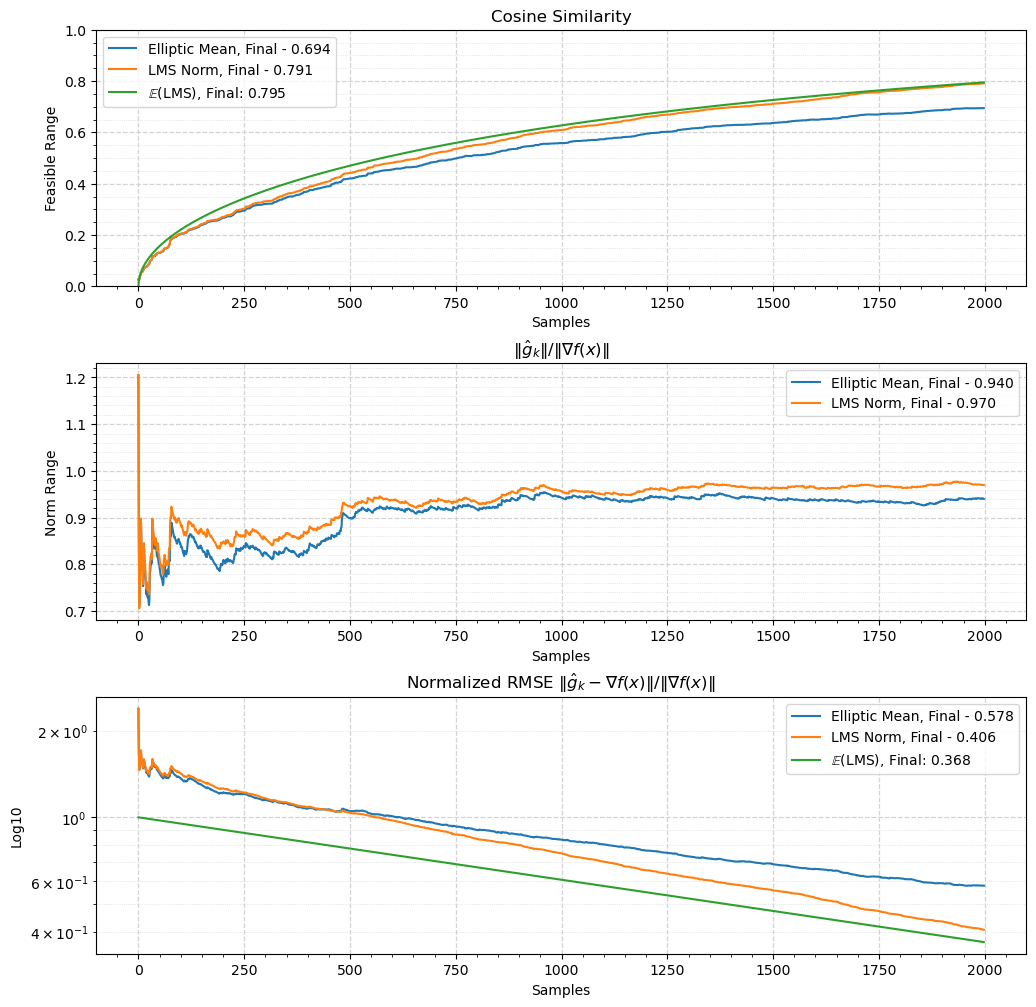

In [4]:
from utils import alpha_to_sigma
import random as rand
sd=rand.randint(0,10000000)
set_seed(sd)
dims=2000
random_gauss_surface(dims) #remove seed init artifacts.
A = random_gauss_surface(dims)

sd+=1
#print(A)
samps=2000#50000#dims+1
x=np.empty((samps,dims),dtype=np.float64)
x[0]= rng.normal(0,4,dims)
# print("f =", value(x[[0]]))
# print("∇f =", grad(x[0]))
t1=tm.perf_counter()
sd+=1
set_seed(sd)
sample_=side2_sample
nfo1=simple_averager(x,sample_gauss,sample_,bias_type=1);set_seed(sd)
nfo2=simple_lms(x,sample_sphere,sample_,bias_type=1);set_seed(sd)
sm=dims**.5
dlt=2**(-52/2)
ns=sm*(least_eps_delta(x,dlt)**2.)#*sm#(2**(-52))*sm
print(ns)
frc=1 / 1500
sigma=alpha_to_sigma(frc, False)#2.45#2.7494#2.7#2.5758#2.5#2.3263#2.5758#3.3#2.5758#2.3263#2.87#2.5758 #2.3263##2.3263#
print(sigma,frc)
# nfo3=stationary_lms_eco(x, sample_sphere, sample_, bias_type=0, alpha=sigma, t_buffer=False,sig=ns,eps=dlt);set_seed(sd)
# nfo4=stationary_lms_eco(x, sample_sphere, sample_, bias_type=0, alpha=sigma, t_buffer=True,sig=ns,eps=dlt);set_seed(sd)
# nfo5=stationary_lms_eco(x, sample_sphere, sample_, bias_type=0, alpha=sigma, t_buffer=True, partial_reset=True,sig=ns,eps=dlt);set_seed(sd)
# nfo6=stationary_lms_eco(x, sample_sphere, sample_, bias_type=0, alpha=sigma, t_buffer=False, partial_reset=True,sig=ns,eps=dlt);set_seed(sd)

def sted_str(nfo,i):return  f'Start-End: {nfo[1, i]:.3f}, {nfo[nfo.shape[0]-1, i]:.3f}'
def end_str(nfo,i):return  f'Final - {nfo[nfo.shape[0]-1, i]:.3f}'

def generic_str(s):
    def _t(nfo,i):return s
    return _t

print(f'Vector Sampling Completed in: {((t2:=tm.perf_counter())-t1):.4f} seconds.')
plot_info([
    [nfo1, f'Elliptic Mean', end_str],
    [nfo2, 'LMS Norm', end_str],
    # [nfo3, 'ECO FR', end_str],
    # [nfo4, 'ECO FR T', end_str],
    # [nfo5, 'ECO PR T', end_str],
    # [nfo6, 'ECO PR', end_str]
],dims, minoryaxes=True)
print(f'Plots generated in: {(tm.perf_counter()-t2):.4f} seconds.')
print('g true norm',np.linalg.norm(grad(x[0])),'total noise scl',rnscl*(x[0].shape[0]))
print('rval', 16 / (dims**2), 4 / (dims), sm / sigma)

#### Marks Ratio Partial Reset Estimator

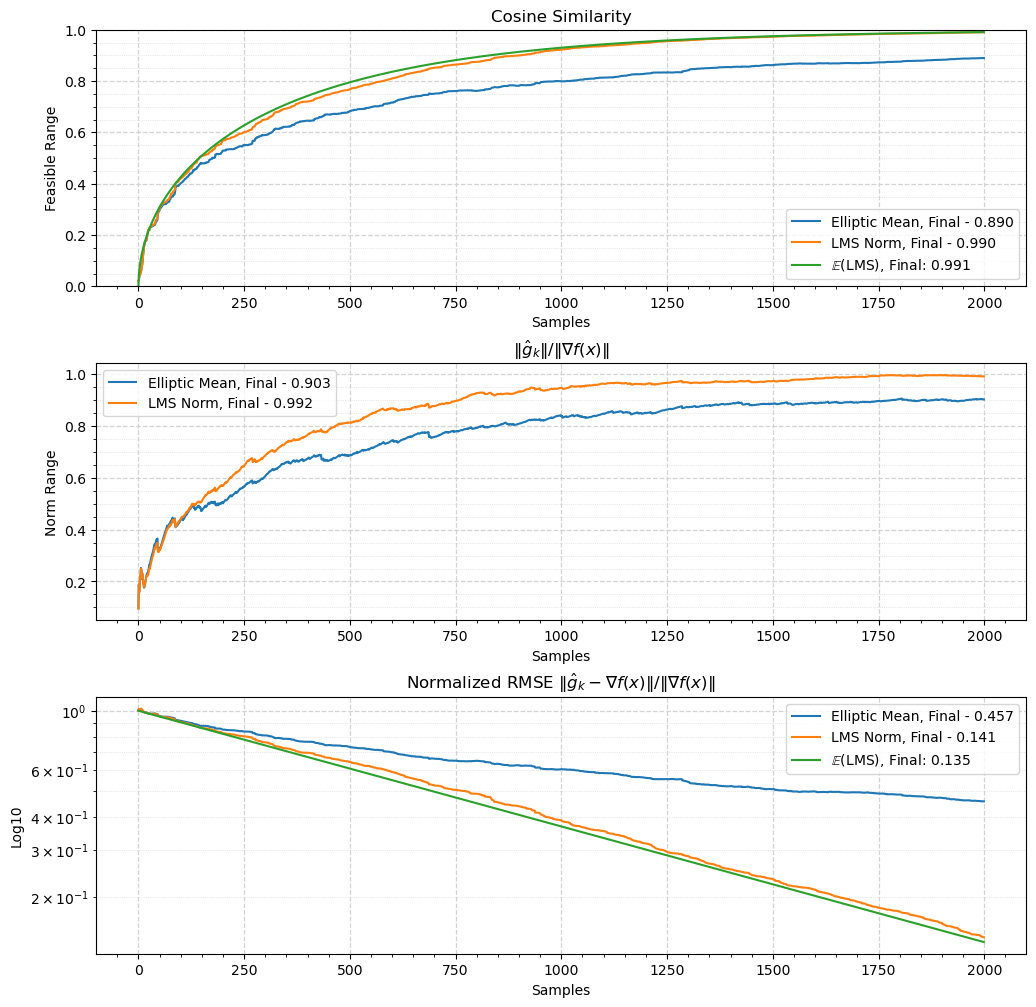

In [7]:
import empirical_benchmarking as ex

ex.dev_test(d=500,s=2000,biastype=2,seed=None)

2.3263478740408408
Largest Bound Violation: 1243.8969996342794 Total Bound Violations 210 , False Positives Rate: 0.014
Largest Bound Violation: 926.300173059907 Total Bound Violations 175 , False Positives Rate: 0.011666666666666667
Largest Bound Violation: 82.06894487625787 Total Bound Violations 6 , False Positives Rate: 0.0004


(<Figure size 1200x1200 with 3 Axes>,
 {0: <Axes: title={'center': 'Cosine Similarity'}, xlabel='Samples', ylabel='Feasible Range'>,
  1: <Axes: title={'center': '$\\|\\hat{g}_k\\|/\\|\\nabla f(x)\\|$'}, xlabel='Samples', ylabel='Norm Range'>,
  2: <Axes: title={'center': 'Normalized RMSE $\\|\\hat{g}_k -\\nabla f(x)\\|/\\|\\nabla f(x)\\|$'}, xlabel='Samples', ylabel='Log10'>})

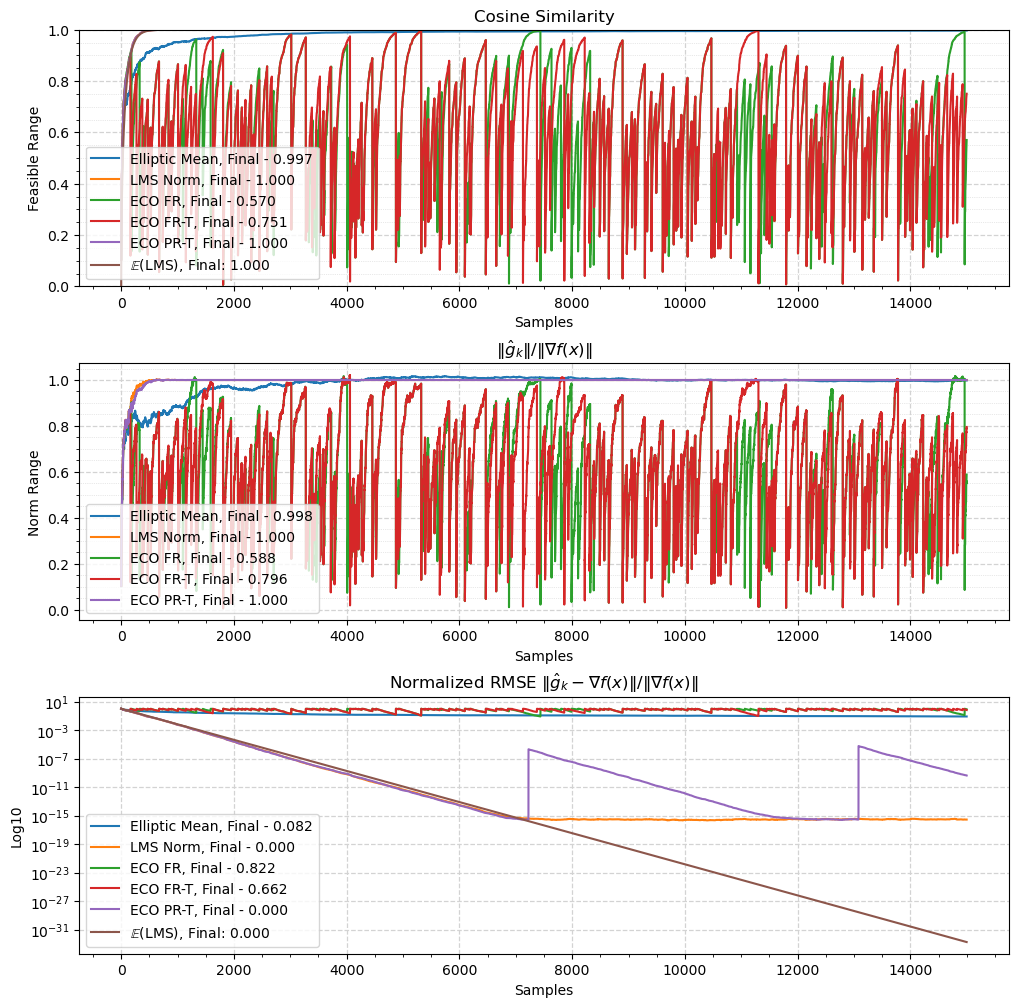

In [8]:
import sampling as sp
import grad_estimators as ge
import utils as ut
import benchmark_functions as bf
import numpy as np

seed=100
sp.set_seed(seed)
d=100
s=15000
frc=1/100
alpha=ut.alpha_to_sigma(frc, False)
print(alpha)
A=bf.random_gauss_sqrmat(d)
x= sp.rng.normal(0,1,d) #np.empty((d,),dtype=np.float64)
S=np.empty((s,d),dtype=np.float64)
sp.sample_sphere(S)
bias_type=0

g_true=bf.grad_sqrmat(x,A)
#We utilize the exact (within f64 representation) directional gradient so that we can validate results meaningfully with noise std=0.
#otherwise we'd need an accurate estimate of STD[f_smooth - f_round] a good estimate is probably the uniform distribution's std, or you can just use \epsilon_{mach} as the largest possible.
c=sp.gradcross_sample(S,g_true) #replace with 1 side or 2 side function eval FD stencils
#c=sp.side1_sample(x,S,lambda p:bf.val_sqrmat(p,A),2**(-52/2))
#c=sp.side2_sample(x,S,lambda p:bf.val_sqrmat(p,A),2**(-52/3))
#because we pregenerate our sample set for building our approximator, we don't need x.
#c,S,g_true
nfo1=ge.simple_averager(c,S,g_true,bias_type)
nfo2=ge.simple_leastchg(c,S,g_true,bias_type)
nfo3=ge.stationary_lms_eco(c,S,g_true,bias_type,alpha=alpha,partial_reset=False,t_buffer=False,)
nfo4=ge.stationary_lms_eco(c,S,g_true,bias_type,alpha=alpha,partial_reset=False,t_buffer=True)
nfo5=ge.stationary_lms_eco(c,S,g_true,bias_type,alpha=alpha,partial_reset=True,t_buffer=True)

def end_str(nfo, i): return f'Final - {nfo[nfo.shape[0] - 1, i]:.3f}'

ut.plot_gradest_info([
    [nfo1, f'Elliptic Mean', end_str],
    [nfo2, 'LMS Norm', end_str],
    [nfo3, f'ECO FR', end_str],
    [nfo4, f'ECO FR-T', end_str],
    [nfo5, f'ECO PR-T', end_str],
],d)

### Theoretical of Monte Carlo Linear MSE convergence vs LMS Exponential (edit labels and get better chart).

[0.99966678 0.99833511 0.99700698 0.99568239 0.9943613  0.99304372
 0.99172963 0.99041901 0.98911185 0.98780813]


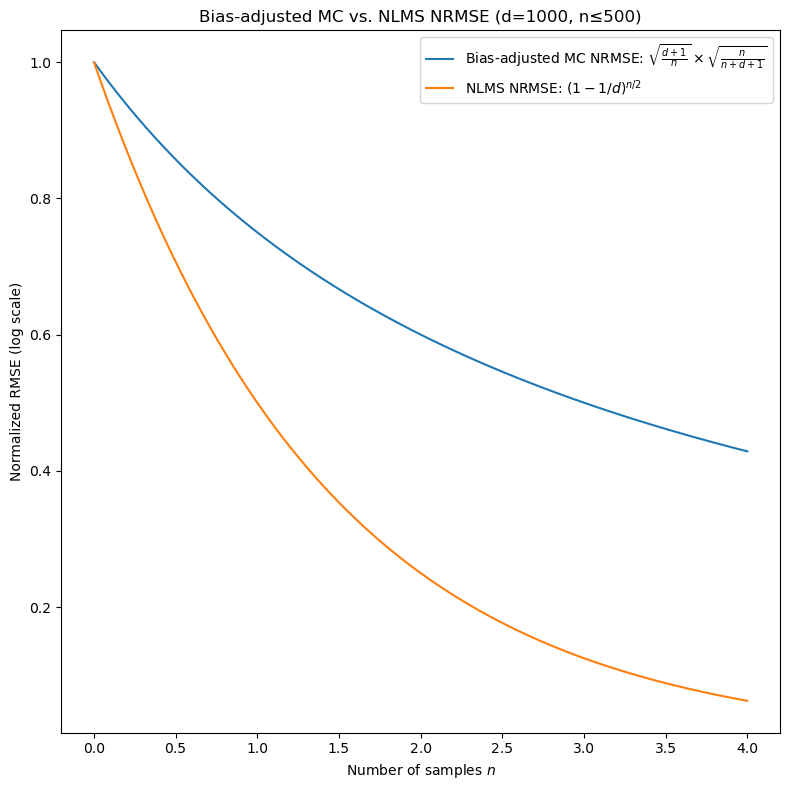

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
d = 2
n_max = 4
n = np.linspace(1/1000, n_max,1000)

# Original MC NRMSE and bias factor
original_mc_nrmse = np.sqrt((d + 1) / n)
bias_factor = np.sqrt((n) / (n + d + 1))

# Bias-adjusted MC NRMSE (original rate * bias factor)
mc_adj_nrmse = (original_mc_nrmse * bias_factor)**2.
mc_adj_cos=np.sqrt(1- mc_adj_nrmse**2)

# NLMS theoretical NRMSE
nlms_nrmse = (1 - 1/d) ** (n)
nlms_cos=np.sqrt(1- nlms_nrmse**2)

print(mc_adj_nrmse[:10])
# Plot on log-linear scale
plt.figure(figsize=(8, 8))
plt.plot(n, mc_adj_nrmse, label=r'Bias-adjusted MC NRMSE: $\sqrt{\frac{d+1}{n}}\times\sqrt{\frac{n}{n+d+1}}$')
plt.plot(n, nlms_nrmse, label=r'NLMS NRMSE: $(1 - 1/d)^{n/2}$')
plt.xlabel('Number of samples $n$')
plt.ylabel('Normalized RMSE (log scale)')
plt.title('Bias-adjusted MC vs. NLMS NRMSE (d=1000, n≤500)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()